In [14]:
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
from rasterio import features


In [ ]:
def print_metrics_percent(results):
    """
    Imprime las métricas.
    """
    if results is None:
        print("No hay resultados para mostrar.")
        return

    def pct(x):
        return f"{x*100:.2f}%" if (x is not None and not isinstance(x, (int,))) else ("N/A" if x is None else f"{x:.2f}%")

    # Obtener valores seguros (maneja nombres alternativos)
    iou = results.get("IoU")
    dice = results.get("DICE")
    pixel = results.get("Pixel_Accuracy")
    f1 = results.get("F1_Score", results.get("F1"))
    tpr = results.get("TPR_Sensitivity_Recall")
    fpr = results.get("FPR")
    precision = results.get("Precision")

    # Contadores absolutos (no convertir a %)
    tp = results.get("TP")
    fp = results.get("FP")
    tn = results.get("TN")
    fn = results.get("FN")

    print(f"   • IoU (Intersection over Union): {pct(iou)}")
    print(f"   • DICE Coefficient:              {pct(dice)}")
    print(f"   • Pixel Accuracy:                {pct(pixel)}")
    print(f"   • F1-Score:                      {pct(f1)}")

    print(f"   • TPR (Sensitivity / Recall):    {pct(tpr)}")
    print(f"   • FPR (False Positive Rate):     {pct(fpr)}")
    print(f"   • Precision:                     {pct(precision)}")

    print(f"   • True Positives (TP):           {int(tp) if tp is not None else 'N/A'}")
    print(f"   • False Positives (FP):          {int(fp) if fp is not None else 'N/A'}")
    print(f"   • True Negatives (TN):           {int(tn) if tn is not None else 'N/A'}")
    print(f"   • False Negatives (FN):          {int(fn) if fn is not None else 'N/A'}")

In [15]:
def geojson_to_raster(geojson_path, reference_tif_path, output_path, codigo_filtro=512):
    """
    Convierte un GeoJSON a raster usando un archivo TIFF de referencia
    
    Args:
        geojson_path: Ruta al archivo GeoJSON
        reference_tif_path: Ruta al TIFF de referencia para obtener dimensiones y proyección
        output_path: Ruta donde guardar el raster resultante
        codigo_filtro: Código a filtrar en el GeoJSON
    """
    gdf = gpd.read_file(geojson_path)
    gdf_filtrado = gdf[gdf['codigo'] == codigo_filtro]
    
    with rasterio.open(reference_tif_path) as ref:
        transform = ref.transform
        width = ref.width
        height = ref.height
        crs = ref.crs
    
    mask = features.rasterize(
            ((geom, 0) for geom in gdf_filtrado.geometry),
            out_shape=(height, width),
            transform=transform,
            fill=1,
            dtype='uint8'
    )
    
    # Guardar el raster
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=mask.dtype,
        crs=crs,
        transform=transform,
    ) as dst:
        dst.write(mask, 1)
        
    return mask

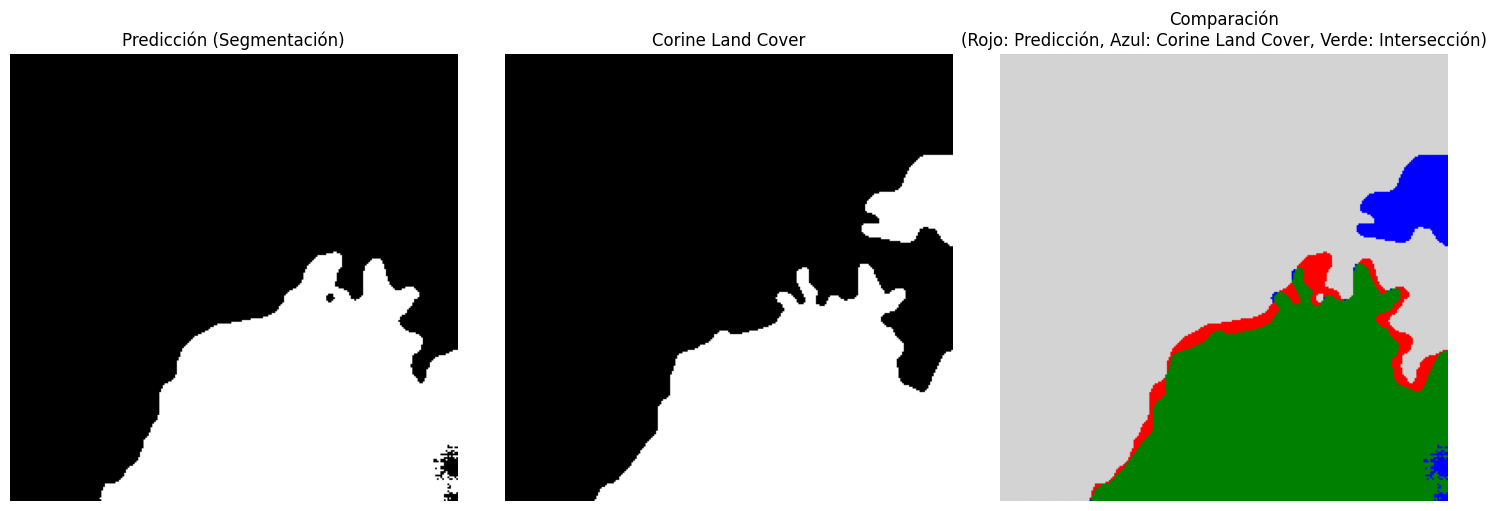

IoU (Intersection over Union): 0.8216
DICE Coefficient:              0.9021
Pixel Accuracy:                0.9432
TPR (Sensitivity/Recall):      0.9084
FPR (False Positive Rate):     0.0427

🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 82.16%
   • DICE Coefficient:              90.21%
   • Pixel Accuracy:                94.32%
   • F1-Score:                      N/A

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    90.84%
   • FPR (False Positive Rate):     4.27%
   • Precision:                     N/A

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           N/A
   • False Positives (FP):          N/A
   • True Negatives (TN):           N/A
   • False Negatives (FN):          N/A


In [63]:
def calculate_dice_iou(mask_path, land_path, target_value=0):
    """
    Calcula las métricas DICE e IoU entre dos rasters binarios
    
    Args:
        mask_path: Ruta al raster de predicción (Segmentación)
        land_path: Ruta al raster de referencia (ground truth - LandUse)
        target_value: Valor que representa la clase de interés (0 para negro)
    
    Returns:
        dict: Diccionario con las métricas calculadas
    """
    with rasterio.open(mask_path) as src1:
        raster1 = src1.read(1)
    
    with rasterio.open(land_path) as src2:
        raster2 = src2.read(1)

    # Convertir a una matriz de 0 y 1
    mask1 = (raster1 == target_value).astype(int)
    mask2 = (raster2 != target_value).astype(int)

    # Calcular intersección y unión
    intersection = np.sum(mask1 & mask2)
    union = np.sum(mask1 | mask2)
    sum_masks = np.sum(mask1) + np.sum(mask2)

    FP = np.sum(mask2) - intersection
    FN = np.sum(mask1) - intersection
    TN = mask1.size - intersection - FP - FN


    # Calculo de las metricas
    if union == 0:
        iou = 1.0 if intersection == 0 else 0.0
        dice = 1.0 if sum_masks == 0 else 0.0
    else:
        iou = intersection / union
        dice = (2 * intersection) / sum_masks if sum_masks > 0 else 0.0

    # Pixel Accuracy: (TP + TN) / Total
    pixel_accuracy = (intersection + TN) / mask1.size
    
    # TPR (True Positive Rate / Sensitivity / Recall): TP / (TP + FN)
    tpr = intersection / (intersection + FN) if (intersection + FN) > 0 else 0.0
    
    # FPR (False Positive Rate): FP / (FP + TN)
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0.0

    comparison = np.zeros_like(mask1, dtype=np.uint8)
    comparison[mask1 == 1] = 1  # AHORA rojo = Corine (antes era predicción)
    comparison[mask2 == 1] = 2  # AHORA azul = Predicción
    comparison[(mask2 == 1) & (mask1 == 1)] = 3
    
    # Visualizar
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(mask1, cmap='gray')
    axes[0].set_title('Predicción (Segmentación)')
    axes[0].axis('off')
    
    axes[1].imshow(mask2, cmap='gray')
    axes[1].set_title('Corine Land Cover')
    axes[1].axis('off')
    
    # Colores personalizados para la comparación
    colors = ['lightgray', 'red', 'blue', 'green']
    cmap = plt.matplotlib.colors.ListedColormap(colors)
    
    im = axes[2].imshow(comparison, cmap=cmap, vmin=0, vmax=3)
    axes[2].set_title('Comparación\n(Rojo: Predicción, Azul: Corine Land Cover, Verde: Intersección)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    
    results = {
        'IoU': iou,
        'DICE': dice,
        'Pixel_Accuracy': pixel_accuracy,
        'TPR_Sensitivity_Recall': tpr,
        'FPR': fpr,
    }
    
    return results

def print_metrics(results):
    """
    Imprime las métricas de forma organizada
    """
    if results is None:
        return

    print(f"IoU (Intersection over Union): {results['IoU']:.4f}")
    print(f"DICE Coefficient:              {results['DICE']:.4f}")
    print(f"Pixel Accuracy:                {results['Pixel_Accuracy']:.4f}")
    print(f"TPR (Sensitivity/Recall):      {results['TPR_Sensitivity_Recall']:.4f}")
    print(f"FPR (False Positive Rate):     {results['FPR']:.4f}")

    print_metrics_percent(results)

results = calculate_dice_iou(
    land_path='../tiles/LandUseRaster/Guatavita_0_crop_raster.tif',
    mask_path='../tiles/segmentacion_automatica/Tesela_0/Guatavita_Nivel1_5._Superficies_de_agua.tif',
    target_value=1
)

print_metrics(results)

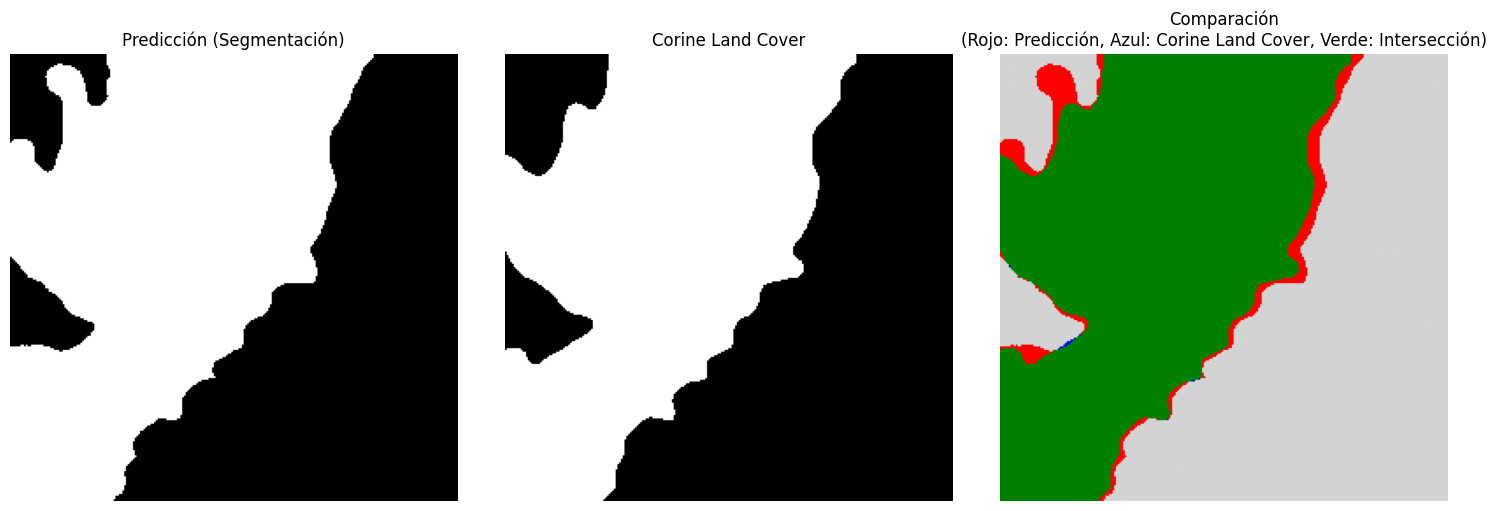

IoU (Intersection over Union): 0.9331
DICE Coefficient:              0.9654
Pixel Accuracy:                0.9654
TPR (Sensitivity/Recall):      0.9337
FPR (False Positive Rate):     0.0006

🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 93.31%
   • DICE Coefficient:              96.54%
   • Pixel Accuracy:                96.54%
   • F1-Score:                      N/A

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    93.37%
   • FPR (False Positive Rate):     0.06%
   • Precision:                     N/A

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           N/A
   • False Positives (FP):          N/A
   • True Negatives (TN):           N/A
   • False Negatives (FN):          N/A


In [45]:
raster = geojson_to_raster(
    geojson_path='../tiles/LandUse/Guatavita_1_crop.geojson',
    reference_tif_path='../tiles/Sentinel/Guatavita_1_crop.tif',
    output_path='../tiles/LandUseRaster/Guatavita_1_crop_raster_bosques.tif',
    codigo_filtro=321113
)

def calculate_dice_iou(mask_path, land_path, target_value=0):
    """
    Calcula las métricas DICE e IoU entre dos rasters binarios
    
    Args:
        mask_path: Ruta al raster de predicción (Segmentación)
        land_path: Ruta al raster de referencia (ground truth - LandUse)
        target_value: Valor que representa la clase de interés (0 para negro)
    
    Returns:
        dict: Diccionario con las métricas calculadas
    """
    with rasterio.open(mask_path) as src1:
        raster1 = src1.read(1)
    
    with rasterio.open(land_path) as src2:
        raster2 = src2.read(1)

    # Convertir a una matriz de 0 y 1
    mask1 = (raster1 == target_value).astype(int)
    mask2 = (raster2 != target_value).astype(int)

    # Calcular intersección y unión
    intersection = np.sum(mask1 & mask2)
    union = np.sum(mask1 | mask2)
    sum_masks = np.sum(mask1) + np.sum(mask2)

    FP = np.sum(mask2) - intersection
    FN = np.sum(mask1) - intersection
    TN = mask1.size - intersection - FP - FN


    # Calculo de las metricas
    if union == 0:
        iou = 1.0 if intersection == 0 else 0.0
        dice = 1.0 if sum_masks == 0 else 0.0
    else:
        iou = intersection / union
        dice = (2 * intersection) / sum_masks if sum_masks > 0 else 0.0

    # Pixel Accuracy: (TP + TN) / Total
    pixel_accuracy = (intersection + TN) / mask1.size
    
    # TPR (True Positive Rate / Sensitivity / Recall): TP / (TP + FN)
    tpr = intersection / (intersection + FN) if (intersection + FN) > 0 else 0.0
    
    # FPR (False Positive Rate): FP / (FP + TN)
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0.0

    comparison = np.zeros_like(mask1, dtype=np.uint8)
    comparison[mask1 == 1] = 1  # AHORA rojo = Corine (antes era predicción)
    comparison[mask2 == 1] = 2  # AHORA azul = Predicción
    comparison[(mask2 == 1) & (mask1 == 1)] = 3
    
    # Visualizar
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(mask1, cmap='gray')
    axes[0].set_title('Predicción (Segmentación)')
    axes[0].axis('off')
    
    axes[1].imshow(mask2, cmap='gray')
    axes[1].set_title('Corine Land Cover')
    axes[1].axis('off')
    
    # Colores personalizados para la comparación
    colors = ['lightgray', 'red', 'blue', 'green']
    cmap = plt.matplotlib.colors.ListedColormap(colors)
    
    im = axes[2].imshow(comparison, cmap=cmap, vmin=0, vmax=3)
    axes[2].set_title('Comparación\n(Rojo: Predicción, Azul: Corine Land Cover, Verde: Intersección)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    
    results = {
        'IoU': iou,
        'DICE': dice,
        'Pixel_Accuracy': pixel_accuracy,
        'TPR_Sensitivity_Recall': tpr,
        'FPR': fpr,
    }
    
    return results

def print_metrics(results):
    """
    Imprime las métricas de forma organizada
    """
    if results is None:
        return

    print(f"IoU (Intersection over Union): {results['IoU']:.4f}")
    print(f"DICE Coefficient:              {results['DICE']:.4f}")
    print(f"Pixel Accuracy:                {results['Pixel_Accuracy']:.4f}")
    print(f"TPR (Sensitivity/Recall):      {results['TPR_Sensitivity_Recall']:.4f}")
    print(f"FPR (False Positive Rate):     {results['FPR']:.4f}")

    print_metrics_percent(results)

results = calculate_dice_iou(
    land_path='../tiles/LandUseRaster/Guatavita_1_agua_raster_auto.tif',
    mask_path='../tiles/segmentacion_automatica/Tesela_11/Guatavita_Nivel1_5._Superficies_de_agua.tif',
    target_value=1
)

print_metrics(results)

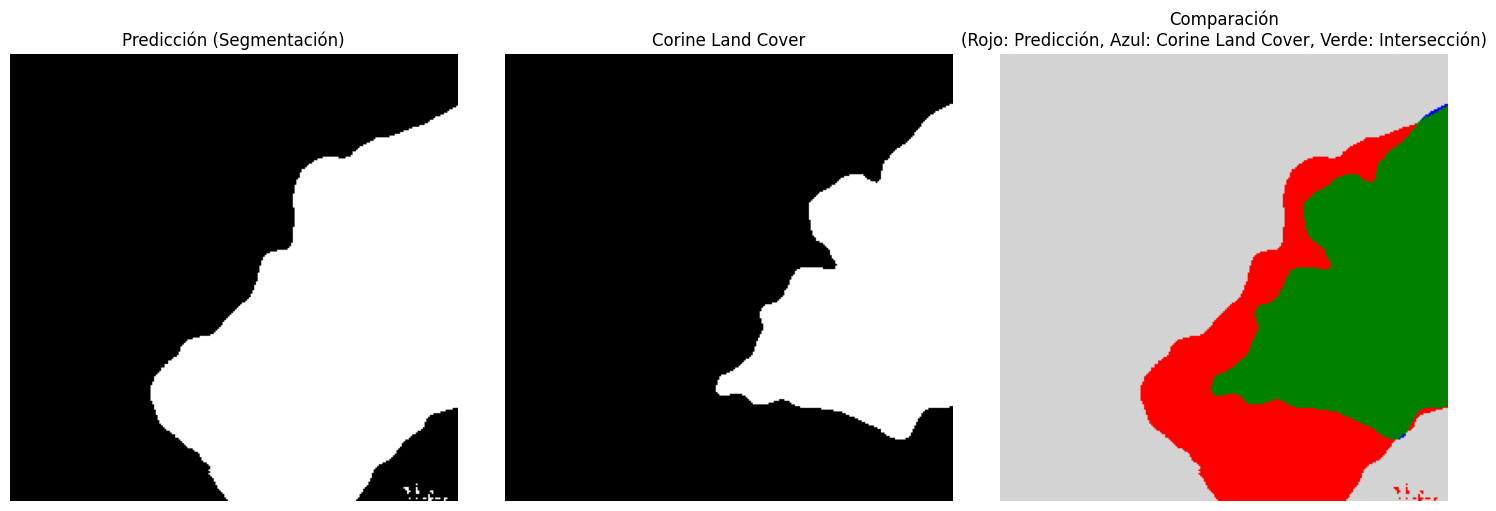

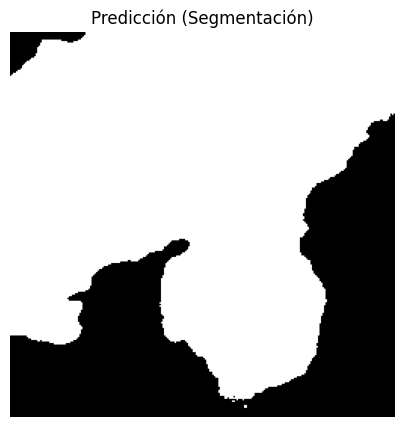

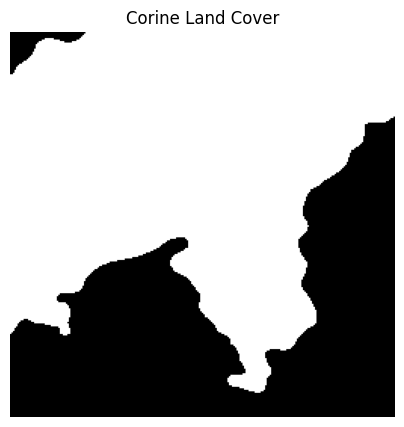

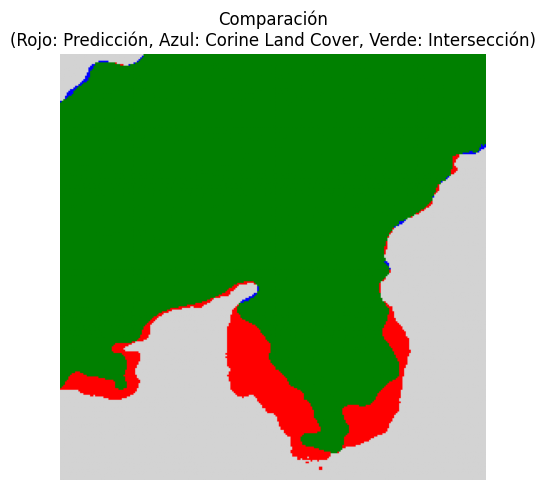

IoU (Intersection over Union): 0.9054
DICE Coefficient:              0.9503
Pixel Accuracy:                0.9357
TPR (Sensitivity/Recall):      0.9078
FPR (False Positive Rate):     0.0057

🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 90.54%
   • DICE Coefficient:              95.03%
   • Pixel Accuracy:                93.57%
   • F1-Score:                      N/A

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    90.78%
   • FPR (False Positive Rate):     0.57%
   • Precision:                     N/A

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           N/A
   • False Positives (FP):          N/A
   • True Negatives (TN):           N/A
   • False Negatives (FN):          N/A


In [56]:
raster = geojson_to_raster(
    geojson_path='../tiles/LandUse/Guatavita_1_crop.geojson',
    reference_tif_path='../tiles/Sentinel/Guatavita_1_crop.tif',
    output_path='../tiles/LandUseRaster/Guatavita_1_crop_raster_bosques.tif',
    codigo_filtro=321113
)

def calculate_dice_iou(mask_path, land_path, target_value=0):
    """
    Calcula las métricas DICE e IoU entre dos rasters binarios
    
    Args:
        mask_path: Ruta al raster de predicción (Segmentación)
        land_path: Ruta al raster de referencia (ground truth - LandUse)
        target_value: Valor que representa la clase de interés (0 para negro)
    
    Returns:
        dict: Diccionario con las métricas calculadas
    """
    with rasterio.open(mask_path) as src1:
        raster1 = src1.read(1)
    
    with rasterio.open(land_path) as src2:
        raster2 = src2.read(1)

    # Convertir a una matriz de 0 y 1
    mask1 = (raster1 == target_value).astype(int)
    mask2 = (raster2 != target_value).astype(int)

    # Calcular intersección y unión
    intersection = np.sum(mask1 & mask2)
    union = np.sum(mask1 | mask2)
    sum_masks = np.sum(mask1) + np.sum(mask2)

    FP = np.sum(mask2) - intersection
    FN = np.sum(mask1) - intersection
    TN = mask1.size - intersection - FP - FN


    # Calculo de las metricas
    if union == 0:
        iou = 1.0 if intersection == 0 else 0.0
        dice = 1.0 if sum_masks == 0 else 0.0
    else:
        iou = intersection / union
        dice = (2 * intersection) / sum_masks if sum_masks > 0 else 0.0

    # Pixel Accuracy: (TP + TN) / Total
    pixel_accuracy = (intersection + TN) / mask1.size
    
    # TPR (True Positive Rate / Sensitivity / Recall): TP / (TP + FN)
    tpr = intersection / (intersection + FN) if (intersection + FN) > 0 else 0.0
    
    # FPR (False Positive Rate): FP / (FP + TN)
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0.0

    comparison = np.zeros_like(mask1, dtype=np.uint8)
    comparison[mask1 == 1] = 1  # AHORA rojo = Corine (antes era predicción)
    comparison[mask2 == 1] = 2  # AHORA azul = Predicción
    comparison[(mask2 == 1) & (mask1 == 1)] = 3
    
    # Visualizar
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    fig, axes1 = plt.subplots(1, 1, figsize=(5, 5))
    fig, axes2 = plt.subplots(1, 1, figsize=(5, 5))

    axes.imshow(mask1, cmap='gray')
    axes.set_title('Predicción (Segmentación)')
    axes.axis('off')

    axes1.imshow(mask2, cmap='gray')
    axes1.set_title('Corine Land Cover')
    axes1.axis('off')
    
    # Colores personalizados para la comparación
    colors = ['lightgray', 'red', 'blue', 'green']
    cmap = plt.matplotlib.colors.ListedColormap(colors)

    im = axes2.imshow(comparison, cmap=cmap, vmin=0, vmax=3)
    axes2.set_title('Comparación\n(Rojo: Predicción, Azul: Corine Land Cover, Verde: Intersección)')
    axes2.axis('off')

    plt.tight_layout()
    plt.show()
    
    
    results = {
        'IoU': iou,
        'DICE': dice,
        'Pixel_Accuracy': pixel_accuracy,
        'TPR_Sensitivity_Recall': tpr,
        'FPR': fpr,
    }
    
    return results

def print_metrics(results):
    """
    Imprime las métricas
    """
    if results is None:
        return

    print(f"IoU (Intersection over Union): {results['IoU']:.4f}")
    print(f"DICE Coefficient:              {results['DICE']:.4f}")
    print(f"Pixel Accuracy:                {results['Pixel_Accuracy']:.4f}")
    print(f"TPR (Sensitivity/Recall):      {results['TPR_Sensitivity_Recall']:.4f}")
    print(f"FPR (False Positive Rate):     {results['FPR']:.4f}")

    print_metrics_percent(results)

results = calculate_dice_iou(
    land_path='../tiles/LandUseRaster/Guatavita_3_agua_raster_auto.tif',
    mask_path='../tiles/segmentacion_automatica/Tesela_16/Guatavita_Nivel1_5._Superficies_de_agua.tif',
    target_value=1
)

print_metrics(results)

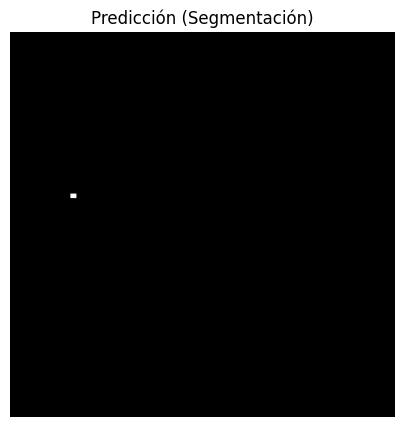

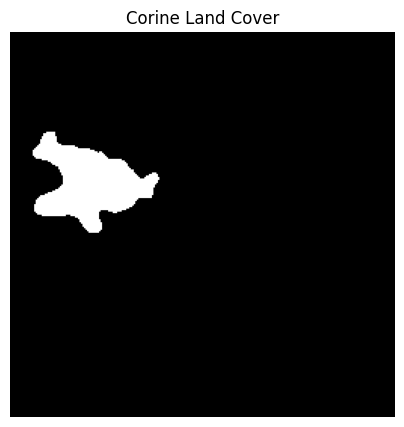

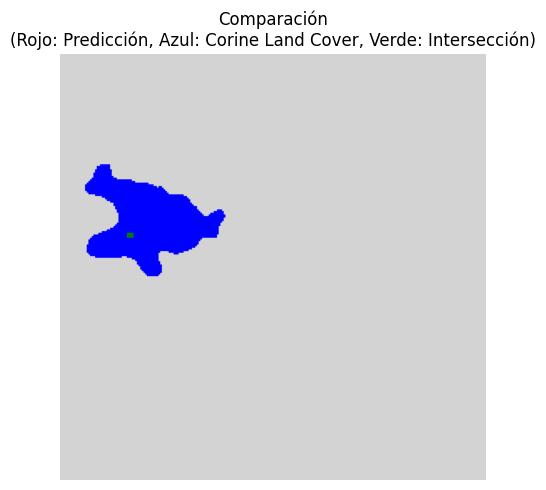

IoU (Intersection over Union): 0.0042
DICE Coefficient:              0.0085
Pixel Accuracy:                0.9567
TPR (Sensitivity/Recall):      1.0000
FPR (False Positive Rate):     0.0433

🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 0.42%
   • DICE Coefficient:              0.85%
   • Pixel Accuracy:                95.67%
   • F1-Score:                      N/A

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    100.00%
   • FPR (False Positive Rate):     4.33%
   • Precision:                     N/A

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           N/A
   • False Positives (FP):          N/A
   • True Negatives (TN):           N/A
   • False Negatives (FN):          N/A


In [51]:
raster = geojson_to_raster(
    geojson_path='../tiles/LandUse/Guatavita_1_crop.geojson',
    reference_tif_path='../tiles/Sentinel/Guatavita_1_crop.tif',
    output_path='../tiles/LandUseRaster/Guatavita_1_crop_raster_bosques.tif',
    codigo_filtro=321113
)

def calculate_dice_iou(mask_path, land_path, target_value=0):
    """
    Calcula las métricas DICE e IoU entre dos rasters binarios
    
    Args:
        mask_path: Ruta al raster de predicción (Segmentación)
        land_path: Ruta al raster de referencia (ground truth - LandUse)
        target_value: Valor que representa la clase de interés (0 para negro)
    
    Returns:
        dict: Diccionario con las métricas calculadas
    """
    with rasterio.open(mask_path) as src1:
        raster1 = src1.read(1)
    
    with rasterio.open(land_path) as src2:
        raster2 = src2.read(1)

    # Convertir a una matriz de 0 y 1
    mask1 = (raster1 == target_value).astype(int)
    mask2 = (raster2 != target_value).astype(int)

    # Calcular intersección y unión
    intersection = np.sum(mask1 & mask2)
    union = np.sum(mask1 | mask2)
    sum_masks = np.sum(mask1) + np.sum(mask2)

    FP = np.sum(mask2) - intersection
    FN = np.sum(mask1) - intersection
    TN = mask1.size - intersection - FP - FN


    # Calculo de las metricas
    if union == 0:
        iou = 1.0 if intersection == 0 else 0.0
        dice = 1.0 if sum_masks == 0 else 0.0
    else:
        iou = intersection / union
        dice = (2 * intersection) / sum_masks if sum_masks > 0 else 0.0

    # Pixel Accuracy: (TP + TN) / Total
    pixel_accuracy = (intersection + TN) / mask1.size
    
    # TPR (True Positive Rate / Sensitivity / Recall): TP / (TP + FN)
    tpr = intersection / (intersection + FN) if (intersection + FN) > 0 else 0.0
    
    # FPR (False Positive Rate): FP / (FP + TN)
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0.0

    comparison = np.zeros_like(mask1, dtype=np.uint8)
    comparison[mask1 == 1] = 1  # AHORA rojo = Corine (antes era predicción)
    comparison[mask2 == 1] = 2  # AHORA azul = Predicción
    comparison[(mask2 == 1) & (mask1 == 1)] = 3
    
    # Visualizar
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    fig, axes1 = plt.subplots(1, 1, figsize=(5, 5))
    fig, axes2 = plt.subplots(1, 1, figsize=(5, 5))

    axes.imshow(mask1, cmap='gray')
    axes.set_title('Predicción (Segmentación)')
    axes.axis('off')

    axes1.imshow(mask2, cmap='gray')
    axes1.set_title('Corine Land Cover')
    axes1.axis('off')
    
    # Colores personalizados para la comparación
    colors = ['lightgray', 'red', 'blue', 'green']
    cmap = plt.matplotlib.colors.ListedColormap(colors)

    im = axes2.imshow(comparison, cmap=cmap, vmin=0, vmax=3)
    axes2.set_title('Comparación\n(Rojo: Predicción, Azul: Corine Land Cover, Verde: Intersección)')
    axes2.axis('off')

    plt.tight_layout()
    plt.show()
    
    
    results = {
        'IoU': iou,
        'DICE': dice,
        'Pixel_Accuracy': pixel_accuracy,
        'TPR_Sensitivity_Recall': tpr,
        'FPR': fpr,
    }
    
    return results

def print_metrics(results):
    """
    Imprime las métricas
    """
    if results is None:
        return

    print(f"IoU (Intersection over Union): {results['IoU']:.4f}")
    print(f"DICE Coefficient:              {results['DICE']:.4f}")
    print(f"Pixel Accuracy:                {results['Pixel_Accuracy']:.4f}")
    print(f"TPR (Sensitivity/Recall):      {results['TPR_Sensitivity_Recall']:.4f}")
    print(f"FPR (False Positive Rate):     {results['FPR']:.4f}")

    print_metrics_percent(results)

results = calculate_dice_iou(
    land_path='../tiles/LandUseRaster/Guatavita_4_urbano_raster_auto.tif',
    mask_path='../tiles/segmentacion_automatica/Tesela_17/Guatavita_Nivel1_1._Territorios_artificializados.tif',
    target_value=1
)

print_metrics(results)

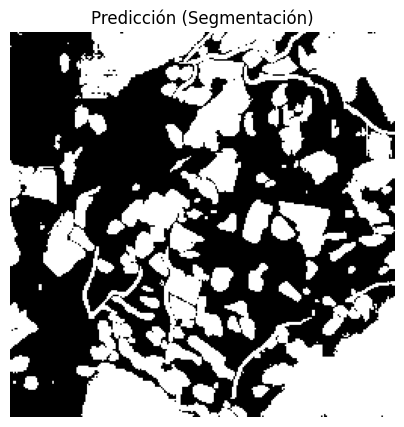

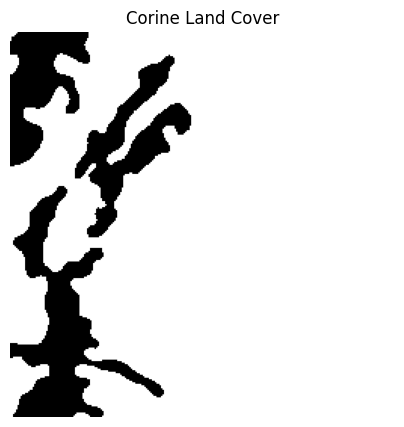

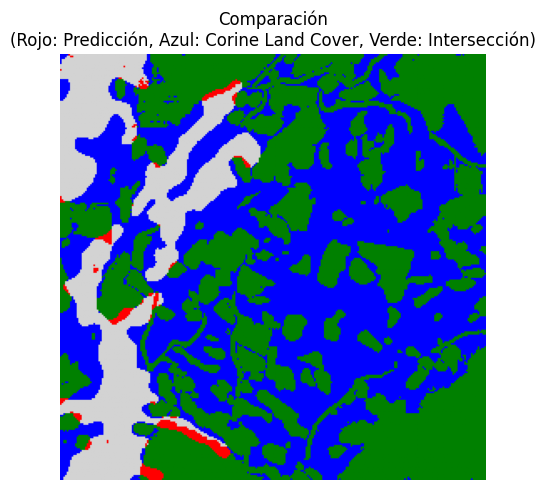

IoU (Intersection over Union): 0.5064
DICE Coefficient:              0.6723
Pixel Accuracy:                0.5771
TPR (Sensitivity/Recall):      0.9761
FPR (False Positive Rate):     0.7420

🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 50.64%
   • DICE Coefficient:              67.23%
   • Pixel Accuracy:                57.71%
   • F1-Score:                      N/A

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    97.61%
   • FPR (False Positive Rate):     74.20%
   • Precision:                     N/A

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           N/A
   • False Positives (FP):          N/A
   • True Negatives (TN):           N/A
   • False Negatives (FN):          N/A


In [55]:
raster = geojson_to_raster(
    geojson_path='../tiles/LandUse/Guatavita_1_crop.geojson',
    reference_tif_path='../tiles/Sentinel/Guatavita_1_crop.tif',
    output_path='../tiles/LandUseRaster/Guatavita_1_crop_raster_bosques.tif',
    codigo_filtro=321113
)

def calculate_dice_iou(mask_path, land_path, target_value=0):
    """
    Calcula las métricas DICE e IoU entre dos rasters binarios
    
    Args:
        mask_path: Ruta al raster de predicción (Segmentación)
        land_path: Ruta al raster de referencia (ground truth - LandUse)
        target_value: Valor que representa la clase de interés (0 para negro)
    
    Returns:
        dict: Diccionario con las métricas calculadas
    """
    with rasterio.open(mask_path) as src1:
        raster1 = src1.read(1)
    
    with rasterio.open(land_path) as src2:
        raster2 = src2.read(1)

    # Convertir a una matriz de 0 y 1
    mask1 = (raster1 == target_value).astype(int)
    mask2 = (raster2 != target_value).astype(int)

    # Calcular intersección y unión
    intersection = np.sum(mask1 & mask2)
    union = np.sum(mask1 | mask2)
    sum_masks = np.sum(mask1) + np.sum(mask2)

    FP = np.sum(mask2) - intersection
    FN = np.sum(mask1) - intersection
    TN = mask1.size - intersection - FP - FN


    # Calculo de las metricas
    if union == 0:
        iou = 1.0 if intersection == 0 else 0.0
        dice = 1.0 if sum_masks == 0 else 0.0
    else:
        iou = intersection / union
        dice = (2 * intersection) / sum_masks if sum_masks > 0 else 0.0

    # Pixel Accuracy: (TP + TN) / Total
    pixel_accuracy = (intersection + TN) / mask1.size
    
    # TPR (True Positive Rate / Sensitivity / Recall): TP / (TP + FN)
    tpr = intersection / (intersection + FN) if (intersection + FN) > 0 else 0.0
    
    # FPR (False Positive Rate): FP / (FP + TN)
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0.0

    comparison = np.zeros_like(mask1, dtype=np.uint8)
    comparison[mask1 == 1] = 1  # AHORA rojo = Corine (antes era predicción)
    comparison[mask2 == 1] = 2  # AHORA azul = Predicción
    comparison[(mask2 == 1) & (mask1 == 1)] = 3
    
    # Visualizar
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    fig, axes1 = plt.subplots(1, 1, figsize=(5, 5))
    fig, axes2 = plt.subplots(1, 1, figsize=(5, 5))

    axes.imshow(mask1, cmap='gray')
    axes.set_title('Predicción (Segmentación)')
    axes.axis('off')

    axes1.imshow(mask2, cmap='gray')
    axes1.set_title('Corine Land Cover')
    axes1.axis('off')
    
    # Colores personalizados para la comparación
    colors = ['lightgray', 'red', 'blue', 'green']
    cmap = plt.matplotlib.colors.ListedColormap(colors)

    im = axes2.imshow(comparison, cmap=cmap, vmin=0, vmax=3)
    axes2.set_title('Comparación\n(Rojo: Predicción, Azul: Corine Land Cover, Verde: Intersección)')
    axes2.axis('off')

    plt.tight_layout()
    plt.show()
    
    
    results = {
        'IoU': iou,
        'DICE': dice,
        'Pixel_Accuracy': pixel_accuracy,
        'TPR_Sensitivity_Recall': tpr,
        'FPR': fpr,
    }
    
    return results

def print_metrics(results):
    """
    Imprime las métricas
    """
    if results is None:
        return

    print(f"IoU (Intersection over Union): {results['IoU']:.4f}")
    print(f"DICE Coefficient:              {results['DICE']:.4f}")
    print(f"Pixel Accuracy:                {results['Pixel_Accuracy']:.4f}")
    print(f"TPR (Sensitivity/Recall):      {results['TPR_Sensitivity_Recall']:.4f}")
    print(f"FPR (False Positive Rate):     {results['FPR']:.4f}")

    print_metrics_percent(results)

results = calculate_dice_iou(
    land_path='../tiles/LandUseRaster/Guatavita_5_agricola_raster_auto.tif',
    mask_path='../tiles/segmentacion_automatica/Tesela_18/Guatavita_Nivel1_2._Territorios_agrícolas.tif',
    target_value=1
)

print_metrics(results)

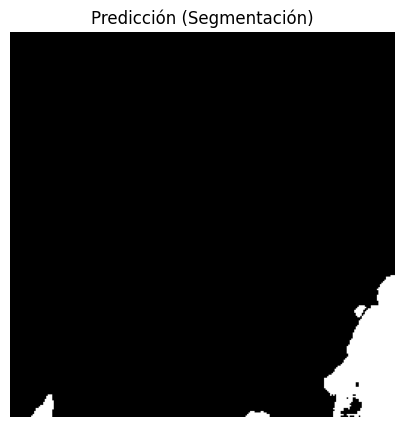

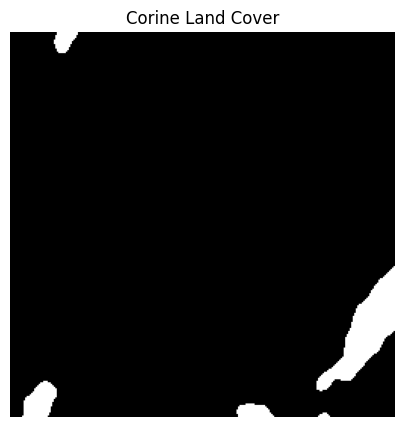

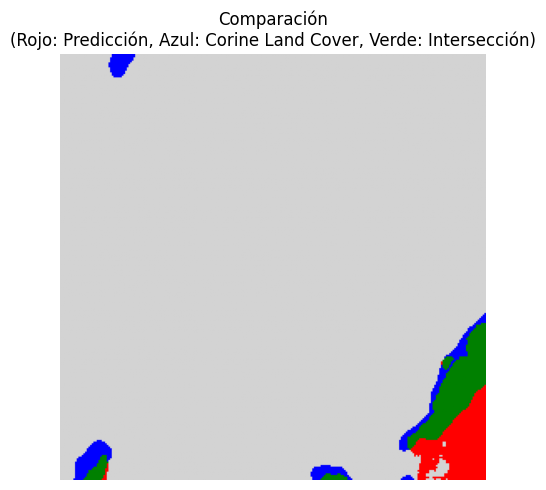

IoU (Intersection over Union): 0.3809
DICE Coefficient:              0.5516
Pixel Accuracy:                0.9644
TPR (Sensitivity/Recall):      0.5032
FPR (False Positive Rate):     0.0146

🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 38.09%
   • DICE Coefficient:              55.16%
   • Pixel Accuracy:                96.44%
   • F1-Score:                      N/A

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    50.32%
   • FPR (False Positive Rate):     1.46%
   • Precision:                     N/A

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           N/A
   • False Positives (FP):          N/A
   • True Negatives (TN):           N/A
   • False Negatives (FN):          N/A


In [57]:
raster = geojson_to_raster(
    geojson_path='../tiles/LandUse/Guatavita_1_crop.geojson',
    reference_tif_path='../tiles/Sentinel/Guatavita_1_crop.tif',
    output_path='../tiles/LandUseRaster/Guatavita_1_crop_raster_bosques.tif',
    codigo_filtro=321113
)

def calculate_dice_iou(mask_path, land_path, target_value=0):
    """
    Calcula las métricas DICE e IoU entre dos rasters binarios
    
    Args:
        mask_path: Ruta al raster de predicción (Segmentación)
        land_path: Ruta al raster de referencia (ground truth - LandUse)
        target_value: Valor que representa la clase de interés (0 para negro)
    
    Returns:
        dict: Diccionario con las métricas calculadas
    """
    with rasterio.open(mask_path) as src1:
        raster1 = src1.read(1)
    
    with rasterio.open(land_path) as src2:
        raster2 = src2.read(1)

    # Convertir a una matriz de 0 y 1
    mask1 = (raster1 == target_value).astype(int)
    mask2 = (raster2 != target_value).astype(int)

    # Calcular intersección y unión
    intersection = np.sum(mask1 & mask2)
    union = np.sum(mask1 | mask2)
    sum_masks = np.sum(mask1) + np.sum(mask2)

    FP = np.sum(mask2) - intersection
    FN = np.sum(mask1) - intersection
    TN = mask1.size - intersection - FP - FN


    # Calculo de las metricas
    if union == 0:
        iou = 1.0 if intersection == 0 else 0.0
        dice = 1.0 if sum_masks == 0 else 0.0
    else:
        iou = intersection / union
        dice = (2 * intersection) / sum_masks if sum_masks > 0 else 0.0

    # Pixel Accuracy: (TP + TN) / Total
    pixel_accuracy = (intersection + TN) / mask1.size
    
    # TPR (True Positive Rate / Sensitivity / Recall): TP / (TP + FN)
    tpr = intersection / (intersection + FN) if (intersection + FN) > 0 else 0.0
    
    # FPR (False Positive Rate): FP / (FP + TN)
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0.0

    comparison = np.zeros_like(mask1, dtype=np.uint8)
    comparison[mask1 == 1] = 1  # AHORA rojo = Corine (antes era predicción)
    comparison[mask2 == 1] = 2  # AHORA azul = Predicción
    comparison[(mask2 == 1) & (mask1 == 1)] = 3
    
    # Visualizar
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    fig, axes1 = plt.subplots(1, 1, figsize=(5, 5))
    fig, axes2 = plt.subplots(1, 1, figsize=(5, 5))

    axes.imshow(mask1, cmap='gray')
    axes.set_title('Predicción (Segmentación)')
    axes.axis('off')

    axes1.imshow(mask2, cmap='gray')
    axes1.set_title('Corine Land Cover')
    axes1.axis('off')
    
    # Colores personalizados para la comparación
    colors = ['lightgray', 'red', 'blue', 'green']
    cmap = plt.matplotlib.colors.ListedColormap(colors)

    im = axes2.imshow(comparison, cmap=cmap, vmin=0, vmax=3)
    axes2.set_title('Comparación\n(Rojo: Predicción, Azul: Corine Land Cover, Verde: Intersección)')
    axes2.axis('off')

    plt.tight_layout()
    plt.show()
    
    
    results = {
        'IoU': iou,
        'DICE': dice,
        'Pixel_Accuracy': pixel_accuracy,
        'TPR_Sensitivity_Recall': tpr,
        'FPR': fpr,
    }
    
    return results

def print_metrics(results):
    """
    Imprime las métricas
    """
    if results is None:
        return

    print(f"IoU (Intersection over Union): {results['IoU']:.4f}")
    print(f"DICE Coefficient:              {results['DICE']:.4f}")
    print(f"Pixel Accuracy:                {results['Pixel_Accuracy']:.4f}")
    print(f"TPR (Sensitivity/Recall):      {results['TPR_Sensitivity_Recall']:.4f}")
    print(f"FPR (False Positive Rate):     {results['FPR']:.4f}")

    print_metrics_percent(results)

results = calculate_dice_iou(
    land_path='../tiles/LandUseRaster/Guatavita_6_bosques_raster_auto.tif',
    mask_path='../tiles/segmentacion_automatica/Tesela_19/Guatavita_Nivel1_3._Bosques_y_áreas_seminaturales.tif',
    target_value=1
)

print_metrics(results)

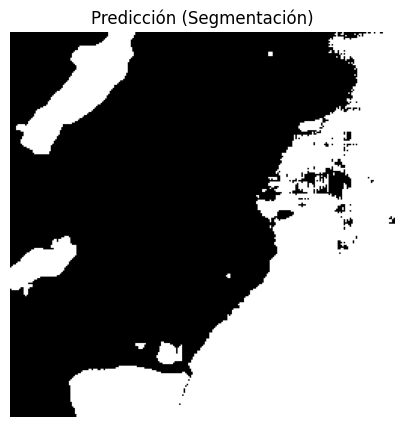

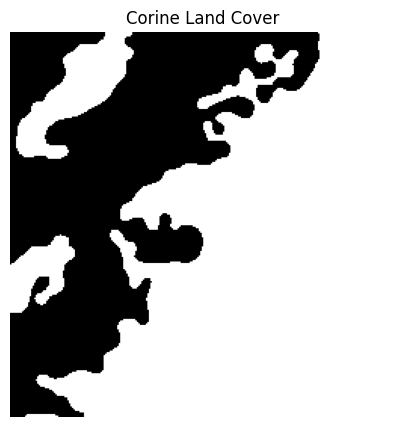

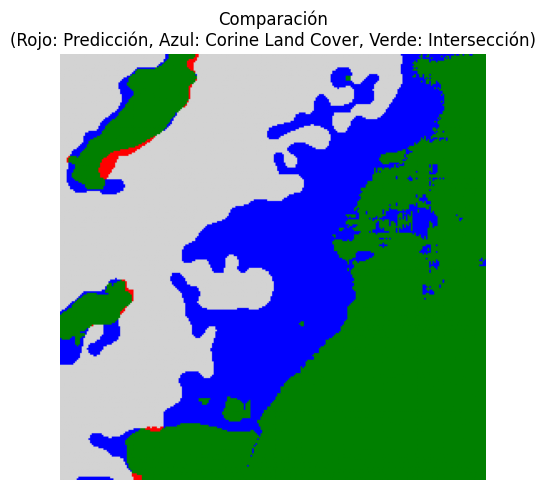

IoU (Intersection over Union): 0.6242
DICE Coefficient:              0.7686
Pixel Accuracy:                0.7571
TPR (Sensitivity/Recall):      0.9886
FPR (False Positive Rate):     0.4025

🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 62.42%
   • DICE Coefficient:              76.86%
   • Pixel Accuracy:                75.71%
   • F1-Score:                      N/A

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    98.86%
   • FPR (False Positive Rate):     40.25%
   • Precision:                     N/A

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           N/A
   • False Positives (FP):          N/A
   • True Negatives (TN):           N/A
   • False Negatives (FN):          N/A


In [66]:
raster = geojson_to_raster(
    geojson_path='../tiles/LandUse/Guatavita_1_crop.geojson',
    reference_tif_path='../tiles/Sentinel/Guatavita_1_crop.tif',
    output_path='../tiles/LandUseRaster/Guatavita_1_crop_raster_bosques.tif',
    codigo_filtro=321113
)

def calculate_dice_iou(mask_path, land_path, target_value=0):
    """
    Calcula las métricas DICE e IoU entre dos rasters binarios
    
    Args:
        mask_path: Ruta al raster de predicción (Segmentación)
        land_path: Ruta al raster de referencia (ground truth - LandUse)
        target_value: Valor que representa la clase de interés (0 para negro)
    
    Returns:
        dict: Diccionario con las métricas calculadas
    """
    with rasterio.open(mask_path) as src1:
        raster1 = src1.read(1)
    
    with rasterio.open(land_path) as src2:
        raster2 = src2.read(1)

    # Convertir a una matriz de 0 y 1
    mask1 = (raster1 == target_value).astype(int)
    mask2 = (raster2 != target_value).astype(int)

    # Calcular intersección y unión
    intersection = np.sum(mask1 & mask2)
    union = np.sum(mask1 | mask2)
    sum_masks = np.sum(mask1) + np.sum(mask2)

    FP = np.sum(mask2) - intersection
    FN = np.sum(mask1) - intersection
    TN = mask1.size - intersection - FP - FN


    # Calculo de las metricas
    if union == 0:
        iou = 1.0 if intersection == 0 else 0.0
        dice = 1.0 if sum_masks == 0 else 0.0
    else:
        iou = intersection / union
        dice = (2 * intersection) / sum_masks if sum_masks > 0 else 0.0

    # Pixel Accuracy: (TP + TN) / Total
    pixel_accuracy = (intersection + TN) / mask1.size
    
    # TPR (True Positive Rate / Sensitivity / Recall): TP / (TP + FN)
    tpr = intersection / (intersection + FN) if (intersection + FN) > 0 else 0.0
    
    # FPR (False Positive Rate): FP / (FP + TN)
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0.0

    comparison = np.zeros_like(mask1, dtype=np.uint8)
    comparison[mask1 == 1] = 1  # AHORA rojo = Corine (antes era predicción)
    comparison[mask2 == 1] = 2  # AHORA azul = Predicción
    comparison[(mask2 == 1) & (mask1 == 1)] = 3
    
    # Visualizar
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    fig, axes1 = plt.subplots(1, 1, figsize=(5, 5))
    fig, axes2 = plt.subplots(1, 1, figsize=(5, 5))

    axes.imshow(mask1, cmap='gray')
    axes.set_title('Predicción (Segmentación)')
    axes.axis('off')

    axes1.imshow(mask2, cmap='gray')
    axes1.set_title('Corine Land Cover')
    axes1.axis('off')
    
    # Colores personalizados para la comparación
    colors = ['lightgray', 'red', 'blue', 'green']
    cmap = plt.matplotlib.colors.ListedColormap(colors)

    im = axes2.imshow(comparison, cmap=cmap, vmin=0, vmax=3)
    axes2.set_title('Comparación\n(Rojo: Predicción, Azul: Corine Land Cover, Verde: Intersección)')
    axes2.axis('off')

    plt.tight_layout()
    plt.show()
    
    
    results = {
        'IoU': iou,
        'DICE': dice,
        'Pixel_Accuracy': pixel_accuracy,
        'TPR_Sensitivity_Recall': tpr,
        'FPR': fpr,
    }
    
    return results

def print_metrics(results):
    """
    Imprime las métricas
    """
    if results is None:
        return

    print(f"IoU (Intersection over Union): {results['IoU']:.4f}")
    print(f"DICE Coefficient:              {results['DICE']:.4f}")
    print(f"Pixel Accuracy:                {results['Pixel_Accuracy']:.4f}")
    print(f"TPR (Sensitivity/Recall):      {results['TPR_Sensitivity_Recall']:.4f}")
    print(f"FPR (False Positive Rate):     {results['FPR']:.4f}")

    print_metrics_percent(results)

results = calculate_dice_iou(
    land_path='../tiles/LandUseRaster/Guatavita_7_bosques_raster_auto.tif',
    mask_path='../tiles/segmentacion_automatica/Tesela_20/Guatavita_Nivel1_3._Bosques_y_áreas_seminaturales.tif',
    target_value=1
)

print_metrics(results)

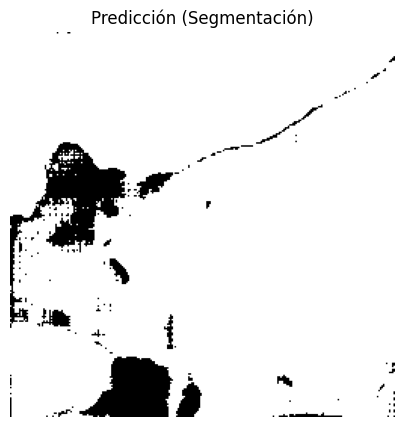

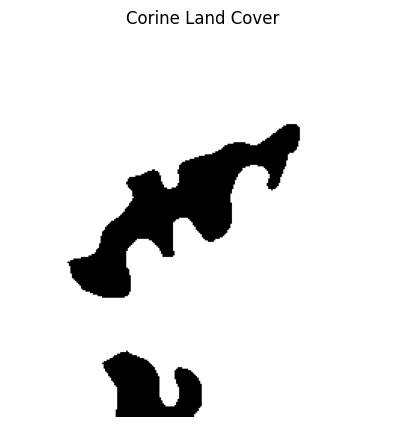

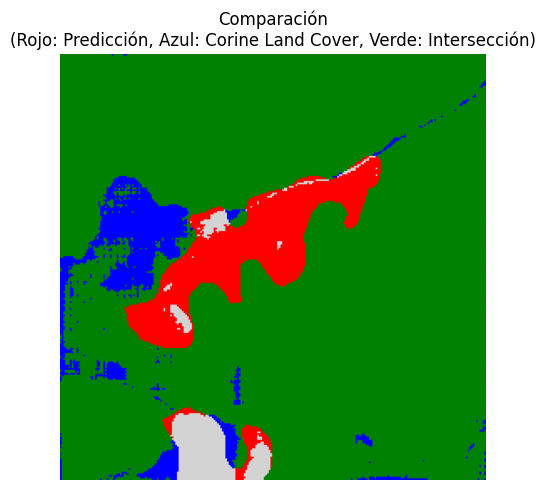

In [59]:
results = calculate_dice_iou(
    land_path='../tiles/LandUseRaster/Guatavita_8_bosques_raster_auto.tif',
    mask_path='../tiles/segmentacion_automatica/Tesela_21/Guatavita_Nivel1_3._Bosques_y_áreas_seminaturales.tif',
    target_value=1
)

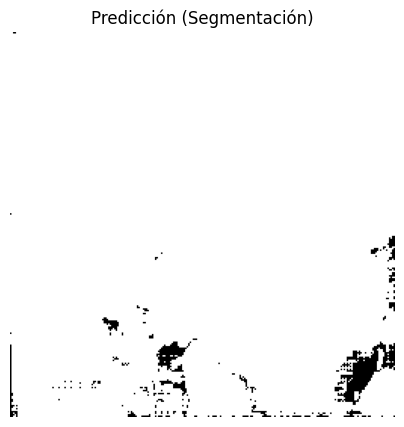

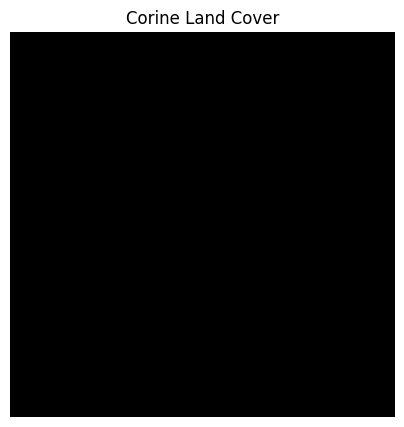

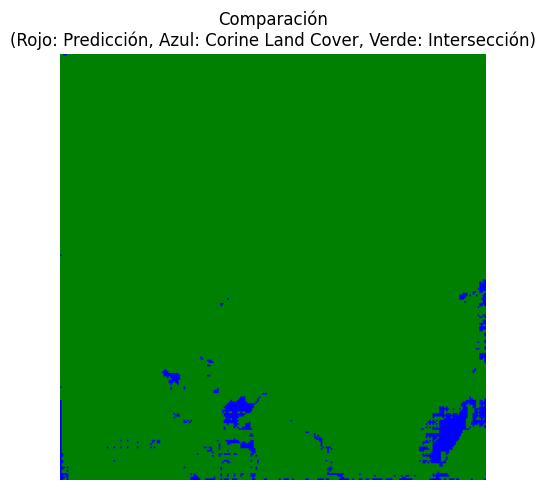

In [62]:
results = calculate_dice_iou(
    land_path='../tiles/LandUseRaster/Guatavita_9_bosques_raster_auto.tif',
    mask_path='../tiles/segmentacion_automatica/Tesela_22/Guatavita_Nivel1_3._Bosques_y_áreas_seminaturales.tif',
    target_value=1
)

In [ ]:
results = calculate_dice_iou(
    land_path='../tiles/LandUseRaster/Guatavita_9_bosques_raster_auto.tif',
    mask_path='../tiles/segmentacion_automatica/Tesela_22/Guatavita_Nivel1_3._Bosques_y_áreas_seminaturales.tif',
    target_value=1
)

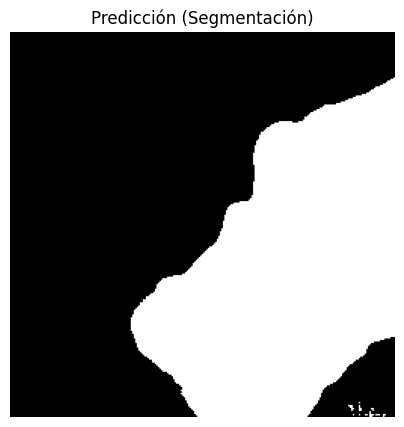

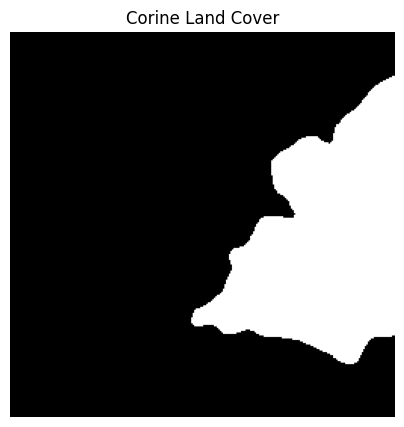

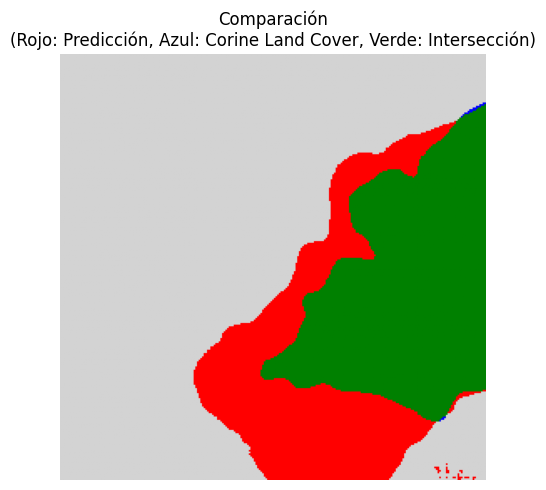

IoU (Intersection over Union): 0.5770
DICE Coefficient:              0.7318
Pixel Accuracy:                0.8391
TPR (Sensitivity/Recall):      0.5777
FPR (False Positive Rate):     0.0007

🎯 MÉTRICAS PRINCIPALES:
   • IoU (Intersection over Union): 57.70%
   • DICE Coefficient:              73.18%
   • Pixel Accuracy:                83.91%
   • F1-Score:                      N/A

📊 SENSIBILIDAD Y ESPECIFICIDAD:
   • TPR (Sensitivity / Recall):    57.77%
   • FPR (False Positive Rate):     0.07%
   • Precision:                     N/A

🔢 MATRIZ DE CONFUSIÓN (conteos):
   • True Positives (TP):           N/A
   • False Positives (FP):          N/A
   • True Negatives (TN):           N/A
   • False Negatives (FN):          N/A


In [68]:
raster = geojson_to_raster(
    geojson_path='../tiles/LandUse/Guatavita_1_crop.geojson',
    reference_tif_path='../tiles/Sentinel/Guatavita_1_crop.tif',
    output_path='../tiles/LandUseRaster/Guatavita_1_crop_raster_bosques.tif',
    codigo_filtro=321113
)

def calculate_dice_iou(mask_path, land_path, target_value=0):
    """
    Calcula las métricas DICE e IoU entre dos rasters binarios
    
    Args:
        mask_path: Ruta al raster de predicción (Segmentación)
        land_path: Ruta al raster de referencia (ground truth - LandUse)
        target_value: Valor que representa la clase de interés (0 para negro)
    
    Returns:
        dict: Diccionario con las métricas calculadas
    """
    with rasterio.open(mask_path) as src1:
        raster1 = src1.read(1)
    
    with rasterio.open(land_path) as src2:
        raster2 = src2.read(1)

    # Convertir a una matriz de 0 y 1
    mask1 = (raster1 == target_value).astype(int)
    mask2 = (raster2 != target_value).astype(int)

    # Calcular intersección y unión
    intersection = np.sum(mask1 & mask2)
    union = np.sum(mask1 | mask2)
    sum_masks = np.sum(mask1) + np.sum(mask2)

    FP = np.sum(mask2) - intersection
    FN = np.sum(mask1) - intersection
    TN = mask1.size - intersection - FP - FN


    # Calculo de las metricas
    if union == 0:
        iou = 1.0 if intersection == 0 else 0.0
        dice = 1.0 if sum_masks == 0 else 0.0
    else:
        iou = intersection / union
        dice = (2 * intersection) / sum_masks if sum_masks > 0 else 0.0

    # Pixel Accuracy: (TP + TN) / Total
    pixel_accuracy = (intersection + TN) / mask1.size
    
    # TPR (True Positive Rate / Sensitivity / Recall): TP / (TP + FN)
    tpr = intersection / (intersection + FN) if (intersection + FN) > 0 else 0.0
    
    # FPR (False Positive Rate): FP / (FP + TN)
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0.0

    comparison = np.zeros_like(mask1, dtype=np.uint8)
    comparison[mask1 == 1] = 1  # AHORA rojo = Corine (antes era predicción)
    comparison[mask2 == 1] = 2  # AHORA azul = Predicción
    comparison[(mask2 == 1) & (mask1 == 1)] = 3
    
    # Visualizar
    fig, axes = plt.subplots(1, 1, figsize=(5, 5))
    fig, axes1 = plt.subplots(1, 1, figsize=(5, 5))
    fig, axes2 = plt.subplots(1, 1, figsize=(5, 5))

    axes.imshow(mask1, cmap='gray')
    axes.set_title('Predicción (Segmentación)')
    axes.axis('off')

    axes1.imshow(mask2, cmap='gray')
    axes1.set_title('Corine Land Cover')
    axes1.axis('off')
    
    # Colores personalizados para la comparación
    colors = ['lightgray', 'red', 'blue', 'green']
    cmap = plt.matplotlib.colors.ListedColormap(colors)

    im = axes2.imshow(comparison, cmap=cmap, vmin=0, vmax=3)
    axes2.set_title('Comparación\n(Rojo: Predicción, Azul: Corine Land Cover, Verde: Intersección)')
    axes2.axis('off')

    plt.tight_layout()
    plt.show()
    
    
    results = {
        'IoU': iou,
        'DICE': dice,
        'Pixel_Accuracy': pixel_accuracy,
        'TPR_Sensitivity_Recall': tpr,
        'FPR': fpr,
    }
    
    return results

def print_metrics(results):
    """
    Imprime las métricas
    """
    if results is None:
        return

    print(f"IoU (Intersection over Union): {results['IoU']:.4f}")
    print(f"DICE Coefficient:              {results['DICE']:.4f}")
    print(f"Pixel Accuracy:                {results['Pixel_Accuracy']:.4f}")
    print(f"TPR (Sensitivity/Recall):      {results['TPR_Sensitivity_Recall']:.4f}")
    print(f"FPR (False Positive Rate):     {results['FPR']:.4f}")

    print_metrics_percent(results)

results = calculate_dice_iou(
    land_path='../tiles/LandUseRaster/Guatavita_2_agua_raster_auto.tif',
    mask_path='../tiles/segmentacion_automatica/Tesela_15/Guatavita_Nivel1_5._Superficies_de_agua.tif',
    target_value=1
)

print_metrics(results)
